## 2D advection
Due: 02.12.2024 @ 23:59


### Instruction
Solve the 2D advection problem with both the CIR and the CTU method:
- on a quadratic, periodic grid, with a 2D gaussian as initial condition
- evolve the solution for multiple passings of the domain
- create an animation comparing the two methods
- discuss if and how the solution diffuses numerically depending on the direction of motion and the resolution

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import itertools

In [35]:
class InfiniteRectangularGrid:
    """
    Snake like grid, where escapine one side "teleports" you to the other
    """

    def __init__(self, center_size):
        """
        Initializes the grid
        """
        self.size = center_size
        self.subgrid = np.zeros((self.size, self.size))
        self.x = np.linspace(0, 1, self.size)
        self.y = np.linspace(0, 1, self.size)

    def __getitem__(self, index):
        """
        Defines the getter for InfiniteRectangularGrid[x, y]
        """
        x, y = index
        x, y = x % self.size, y % self.size # infinite  grid effect

        return self.subgrid[x, y]


    def __setitem__(self, index, value):
        """
        Defines InfiniteRectangularGrid[x, y] = something
        """
        x, y = index
        x, y = x % self.size, y % self.size # infinite grid effect

        self.subgrid[x, y] = value

    def __repr__(self):
        """
        Defines that the print statement on this function print the subgrid
        """
        return str(self.subgrid)

    def __array__(self):
        """
        Makes the grid compatible with matplotlib
        eg: matplotlib.pyplot.imshow(InfiniteRectangularGrid) acts the same as if the grid were a numpy 2d array
        """
        return self.subgrid

    def copy(self):
        """
        Returns a InfiniteRectangularGrid with the same properties as this one
        """

        copied_object = InfiniteRectangularGrid(self.size)
        copied_object = self.subgrid.copy()

        return copied_object

In [36]:
def gaussian(x, y, x0=20, y0=20, sigx=5, sigy=5, A=1):
    return A * np.exp(-((((x - x0)**2)/(2 * sigx**2)) + (((y - y0)**2)/(2 * sigy**2))))

def CIR(rho, size, ca=0.5, cb=0.5):
    new_rho = rho.copy()

    for x, y in itertools.product(range(size), range(size)):
        x_contribution = ca * rho[x - 1, y] + (1 - ca) * rho[x, y]
        y_contribution = cb * rho[x, y - 1] + (1 - cb) * rho[x, y]
        new_rho[x, y] = x_contribution + y_contribution - rho[x, y]

    return new_rho


def CTU(rho, size, ca=0.5, cb=0.5):
    new_rho = rho.copy()

    for x,y in itertools.product(range(size), range(size)):
        new_rho[x, y] = (1 - ca) * (1 - cb) * rho[x, y] \
            + ca * (1 - cb) * rho[x-1, y] \
            + (1 - ca) * cb * rho[x, y-1] \
            + ca * cb * rho[x - 1, y - 1]
            
    return new_rho

def evolve(rho, method, size, tend=100, ca=0.5, cb=0.5):
    rhos = [rho.copy()]
    for i in range(1, tend):
        rho = method(rho, size, ca, cb)
        rhos.append(rho.copy())
    return rhos

def animate_rhos(rhos, method):
    fig, ax = plt.subplots()
    ax.set_title(f"Method: {method}")
    img = ax.imshow(rhos[0].T, cmap='viridis', origin='lower')

    def update(frame):
        img.set_array(rhos[frame % len(rhos)].T)
        return img
    
    anim = animation.FuncAnimation(fig, update, frames=len(rhos))
    writer = animation.PillowWriter(fps=30)
    anim.save(f"{method}.gif", writer=writer)

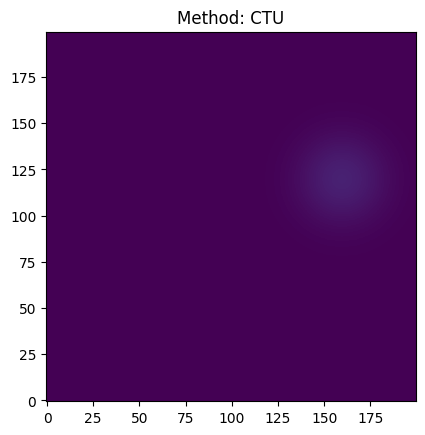

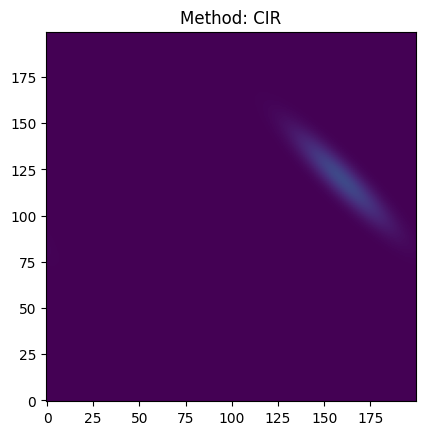

In [37]:
size = 200
N = 1000
ca = 0.5
cb = 0.5

# Initialize the rectangular grid
rho = InfiniteRectangularGrid(size)


# Define the gaussian distribution on the grid
for x, y in itertools.product(range(size), range(size)):
    rho[x, y] = gaussian(x, y, x0=60, y0=20, sigx=5, sigy=5, A=1)

ctu_rhos = evolve(rho, CTU, size=size, tend=N)
animate_rhos(ctu_rhos, "CTU")

cir_rhos = evolve(rho, CIR, size=size, tend=N)
animate_rhos(cir_rhos, "CIR")